In [14]:
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import numpy as np 
import pickle
from numpy import pi
import operator
import pandas as pd

creator.create("obj", base.Fitness, weights=(1.0,))
creator.create("Ind", list, fitness=creator.obj)

/Users/gwenchee/mambaforge3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'obj' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/gwenchee/mambaforge3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Ind' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [15]:
checkpoint_file = "checkpoint.pkl"
with open(checkpoint_file, "rb") as cp_file:
    cp = pickle.load(cp_file)

In [16]:
def get_ind_list(pop_list, index):
    ind_list = [] 
    for pop in pop_list:
        ind_list.append(pop[index])
    return ind_list

In [17]:
def plot_1_obj(logbook, index, obj_name, short_name, save_fig, save_fig_title):
    gen = np.array(logbook.select("gen")) + 1
    obj_avg = get_ind_list(logbook.chapters["oup"].select("avg"), index)
    obj_std = get_ind_list(logbook.chapters["oup"].select("std"), index)
    obj_min = get_ind_list(logbook.chapters["oup"].select("min"), index)
    obj_max = get_ind_list(logbook.chapters["oup"].select("max"), index)
    plt.rc('font', family='serif')
    fig, ax = plt.subplots(figsize=(15,7))
    ax.errorbar(gen, obj_avg, yerr=obj_std, label="Ave "+ short_name, capsize=5)
    ax.plot(gen, obj_min, "*-", label="Min "+ short_name)
    ax.plot(gen, obj_max, "*-", label="Max "+ short_name)
    ax.set_xlabel("Generation [#]", fontsize=20)
    ax.set_ylabel(obj_name + " ("+short_name+") [K]", fontsize=18)
    ax.grid()
    handles, labels = ax.get_legend_handles_labels()
    ax.set_ylim(1100, 1325)
    ax.legend(handles, labels, fontsize=18, bbox_to_anchor = [1.0, 1.0])
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_title(obj_name + " Evolution", fontsize=24)
    if save_fig:
        plt.savefig(save_fig_title,bbox_inches='tight', dpi=300)

In [18]:
logbook = cp["logbook"]

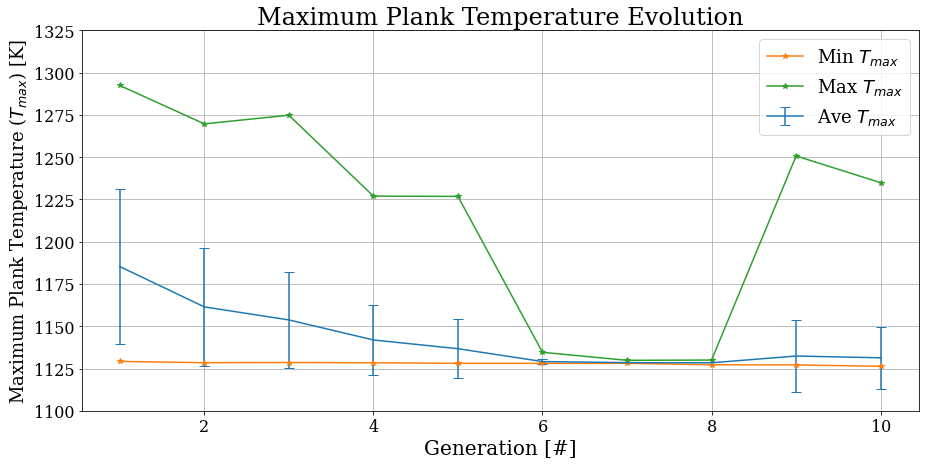

In [19]:
plot_1_obj(logbook, 0, "Maximum Plank Temperature", "$T_{max}$", True, "slab-obj-1-temp-evol.png")

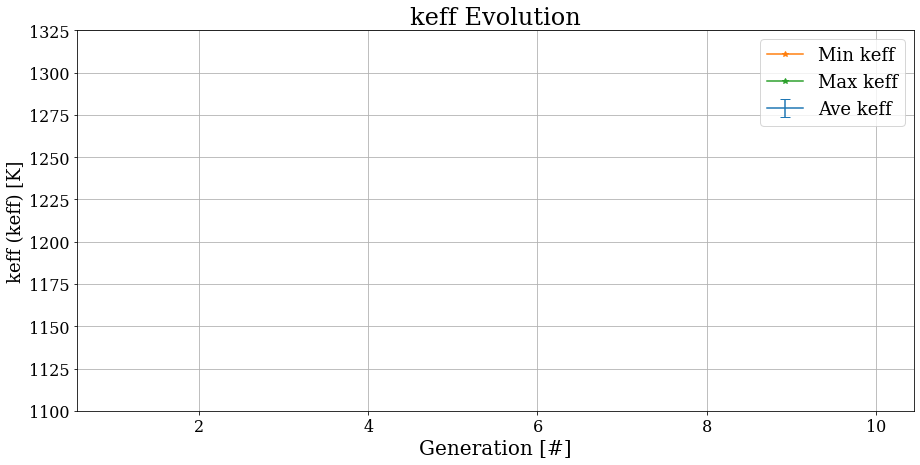

In [20]:
plot_1_obj(logbook, 1, "keff", "keff", False, "")

In [21]:
def sine_curve(ind, pf_present):
    if pf_present:
        pf, a, b, c = ind[0], ind[1], ind[2], ind[3]
    else:
        a, b, c = ind[0], ind[1], ind[2]
        pf = 0.0979
    boundaries = np.arange(2,27.1,2.31)
    midpoints = [] 
    for x in range(len(boundaries)-1):
        midpoints.append((boundaries[x]+boundaries[x+1])/2)
    midpoints = np.array(midpoints)
    x = midpoints
    x1 = np.arange(2, 24.8, 0.01)
    T_pitch = 0.09266
    vol_total = 23.1 * 2.55 * T_pitch * 20
    vol_triso = 4 / 3 * np.pi * 4235e-5 ** 3
    no_trisos = pf * vol_total / vol_triso
    vol_slice = 2.31 * 2.55 * T_pitch * 20
    sine = a * np.sin(b*x + c) + 2
    sine1 = a * np.sin(b*x1 + c) + 2
    sine1 = sine1 / sum(sine) * no_trisos * vol_triso / vol_slice
    sine = sine / sum(sine) * no_trisos * vol_triso / vol_slice
    return x, sine, x1, sine1 

best [0.04793925169533307, 0.47587477955976276, 1.4600732097610898]
std 0.001536386750035679


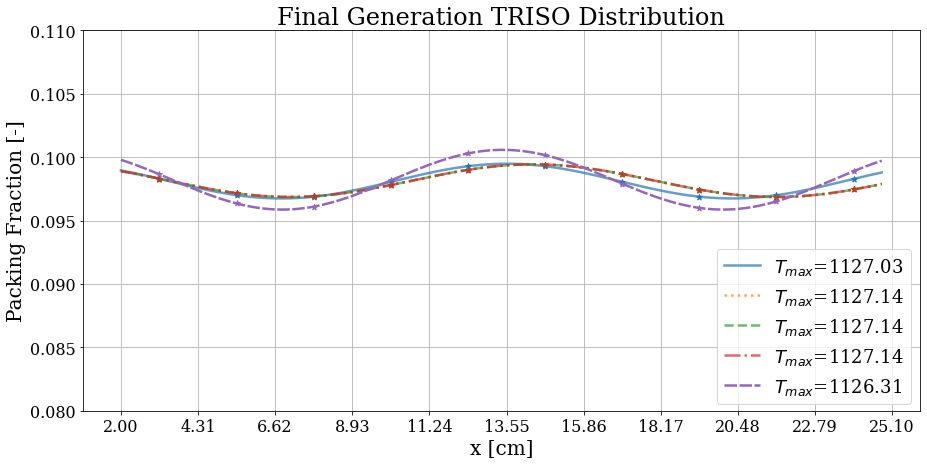

In [22]:
results = cp["all"]
plt.rc('font', family='serif')
fig, ax = plt.subplots(figsize=(15,7))
colors = 2*["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan", "tab:blue","tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]
line_styles = ["-", ":", "--", "-.", (0, (5, 1))]
oup_results = results["outputs"]
count = 0
for i, pop in enumerate(results["populations"]):
    obj_0 = np.array([item[0] for item in oup_results[i]])
    sorted_index_0 = np.argsort(obj_0)
    if i == 9:
        for j, ind in enumerate(pop):
            if j == sorted_index_0[0]:
                print("best", ind)
                x, sine, x1, sine1 = sine_curve(ind, False)
                print("std", np.std(sine))
                ax.scatter(x, sine, marker='*')
                ax.plot(x1, sine1, alpha=1, label="$T_{max}$="+str(round(ind.output[0],2)), 
                        linestyle=line_styles[count], color=colors[count], linewidth=2.5)
                count += 1
            if j in sorted_index_0[1:5]:
                x, sine, x1, sine1 = sine_curve(ind, False)
                ax.scatter(x, sine, marker='*')
                ax.plot(x1, sine1, alpha=0.7, label="$T_{max}$="+str(round(ind.output[0],2)), 
                        linestyle=line_styles[count], color=colors[count], linewidth=2.5)
                count += 1
ax.grid()
ax.set_ylim(0.08,0.11)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=18, bbox_to_anchor = [1.0, 0.45])
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xticks(np.arange(2,27.1,2.31))
ax.set_xlabel("x [cm]", fontsize=20)
ax.set_ylabel("Packing Fraction [-]", fontsize=20)
ax.set_title('Final Generation TRISO Distribution', fontsize=24)
plt.savefig("slab-obj-1-temp-final.png",bbox_inches='tight', dpi=300)

Text(0.5, 1.0, 'Final Generation TRISO Distribution')

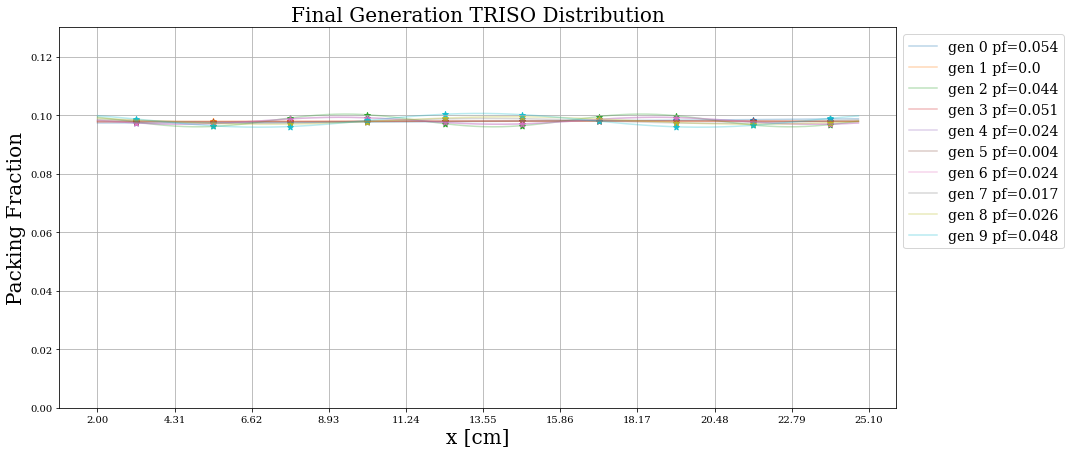

In [23]:
results = cp["all"]
plt.rc('font', family='serif')
fig, ax = plt.subplots(figsize=(15,7))
colors = 2*["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan", "tab:blue","tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]
oup_results = results["outputs"]
for i, pop in enumerate(results["populations"]):
    obj_0 = np.array([item[0] for item in oup_results[i]])
    sorted_index_0 = np.argsort(obj_0)
    if i >= 0:
        for j, ind in enumerate(pop):
            if j == sorted_index_0[0]:
                x, sine, x1, sine1 = sine_curve(ind, False)
                ax.scatter(x, sine, marker='*')
                ax.plot(x1, sine1, alpha=0.3, label="gen "+ str(i)+ " pf=" + str(round(ind[0],3)))
                
ax.grid()
ax.set_ylim(0.00,0.13)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=14, bbox_to_anchor = [1.0, 1.0])
ax.set_xticks(np.arange(2,27.1,2.31))
ax.set_xlabel("x [cm]", fontsize=20)
ax.set_ylabel("Packing Fraction", fontsize=20)
ax.set_title('Final Generation TRISO Distribution', fontsize=20)

In [24]:
df = pd.read_csv("./best_ind/fhr_plank_moltres_csv_flux_centerline_0003.csv")
df1 = pd.read_csv("../../moltres_option4/constant_0.0979/fhr_plank_multiphysics_csv_flux_centerline_0003.csv")

In [26]:
max(df['temp']) - max(df1['temp'])

-1.8338586289999057

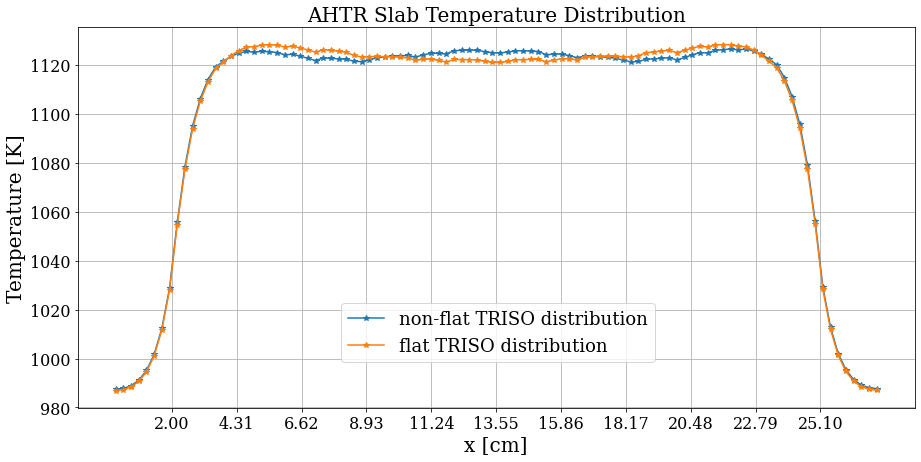

In [25]:
plt.rc('font', family='serif')
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(df['x'], df['temp'], marker='*', label='non-flat TRISO distribution')
ax.plot(df1['x'], df1['temp'], marker='*', label='flat TRISO distribution')
ax.grid()
ax.set_xticks(np.arange(2,27.1,2.31))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=18, bbox_to_anchor = [0.7, 0.3])
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel("x [cm]", fontsize=20)
ax.set_ylabel("Temperature [K]", fontsize=20)
ax.set_title('AHTR Slab Temperature Distribution', fontsize=20)
plt.savefig("slab-obj-1-temp-distr.png",bbox_inches='tight', dpi=300)

Text(0.5, 1.0, 'Flux Distribution')

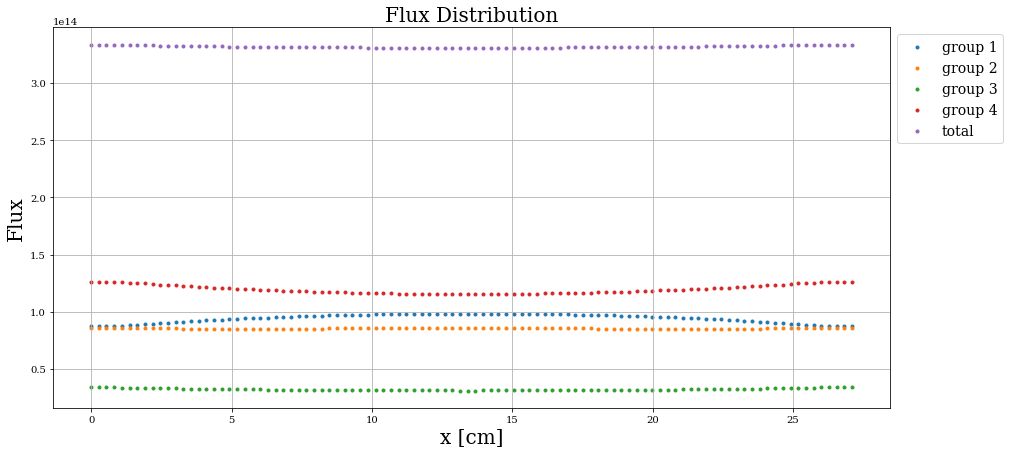

In [14]:
plt.rc('font', family='serif')
fig, ax = plt.subplots(figsize=(15,7))
ax.scatter(df['x'], df['group1'], marker='.', label='group 1')
ax.scatter(df['x'], df['group2'], marker='.', label='group 2')
ax.scatter(df['x'], df['group3'], marker='.', label='group 3')
ax.scatter(df['x'], df['group4'], marker='.', label='group 4')
total_flux = np.array(df['group1']) + np.array(df['group2']) + np.array(df['group3']) + np.array(df['group4'])
ax.scatter(df['x'], total_flux, marker='.', label='total')
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=14, bbox_to_anchor = [1.0, 1.0])
#ax.set_ylim(0.00,3.336e14)
ax.set_xlabel("x [cm]", fontsize=20)
ax.set_ylabel("Flux", fontsize=20)
ax.set_title('Flux Distribution', fontsize=20)

In [15]:
df

,group1,group2,group3,group4,id,temp,x,y,z
0,87217290215565,85824627075942,33998373284102,1.264273e+14,0.000000,987.411555,0.000000,1.625,0
1,87255820173207,85820509561085,33988248789608,1.263907e+14,0.273737,987.777332,0.273737,1.625,0
2,87360068847528,85809335515113,33960891495326,1.262921e+14,0.547475,988.878614,0.547475,1.625,0
3,87537676769810,85790181186447,33914398114616,1.261247e+14,0.821212,991.124130,0.821212,1.625,0
4,87787465060028,85762983626145,33849265319188,1.258910e+14,1.094949,995.135908,1.094949,1.625,0
...,...,...,...,...,...,...,...,...,...
95,87857840478065,85785665168416,33893415739055,1.258770e+14,26.005051,995.443101,26.005051,1.625,0
96,87606742512604,85814089554980,33959686456186,1.261101e+14,26.278788,991.414229,26.278788,1.625,0
97,87428204173621,85834121432093,34006997335420,1.262769e+14,26.552525,989.159146,26.552525,1.625,0
98,87323409684737,85845812445751,34034837527469,1.263753e+14,26.826263,988.053173,26.826263,1.625,0
